In [1]:
from __future__ import division, print_function
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from google.colab import files
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

In [2]:
uploaded = files.upload()

Saving financial_regression.csv to financial_regression.csv


In [3]:
# 1. Загрузка данных
data_path = 'financial_regression.csv'
df = pd.read_csv(data_path)

# Анализ структуры данных
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 47 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                3904 non-null   object 
 1   sp500 open          3719 non-null   float64
 2   sp500 high          3719 non-null   float64
 3   sp500 low           3719 non-null   float64
 4   sp500 close         3719 non-null   float64
 5   sp500 volume        3719 non-null   float64
 6   sp500 high-low      3719 non-null   float64
 7   nasdaq open         3719 non-null   float64
 8   nasdaq high         3719 non-null   float64
 9   nasdaq low          3719 non-null   float64
 10  nasdaq close        3719 non-null   float64
 11  nasdaq volume       3719 non-null   float64
 12  nasdaq high-low     3719 non-null   float64
 13  us_rates_%          176 non-null    float64
 14  CPI                 176 non-null    float64
 15  usd_chf             3694 non-null   float64
 16  eur_us

In [13]:
# Пример задачи бинарной классификации: создадим целевой столбец `target`
# Например: цена закрытия SP500 > медианы за день — класс 1, иначе — класс 0
df['target'] = (df['sp500 close'] > df['sp500 close'].median()).astype(int)

# 2.1 Создание синтезированных признаков
df['sp500_change'] = (df['sp500 close'] - df['sp500 open']) / df['sp500 open']
df['nasdaq_change'] = (df['nasdaq close'] - df['nasdaq open']) / df['nasdaq open']

# Выбор признаков
X = df[['sp500_change', 'nasdaq_change', 'us_rates_%', 'CPI']]
y = df['target'] # целевая переменная

# Вывод выбранных признаков
print("\nПризнаки для обучения:")
print(X.head())

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Замена NaN значений на медиану
X_train = X_train.apply(lambda x: x.fillna(x.median()), axis=0)
X_test = X_test.apply(lambda x: x.fillna(x.median()), axis=0)
y_train = y_train.fillna(y_train.median())
y_test = y_test.fillna(y_test.median())

# Просмотр размеров тренировочного и тестового наборов
print("\nРазмеры наборов данных:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Вывод первых 5 строк после масштабирования
print("\nПервые 5 строк после масштабирования:")
print(X_train_scaled[:5])




Признаки для обучения:
   sp500_change  nasdaq_change  us_rates_%  CPI
0      0.003843       0.002810         NaN  NaN
1     -0.009501      -0.013130         NaN  NaN
2           NaN            NaN         NaN  NaN
3      0.012674       0.013708         NaN  NaN
4     -0.003413      -0.007564         NaN  NaN

Размеры наборов данных:
X_train: (3123, 4), X_test: (781, 4)
y_train: (3123,), y_test: (781,)

Первые 5 строк после масштабирования:
[[-0.70493029 -1.19836592 -0.11112888 -0.07337644]
 [-0.07662879 -0.10828295 -0.11112888 -0.07337644]
 [ 0.81114393  1.05517535 -0.11112888 -0.07337644]
 [ 0.14763881  0.34991962 -0.11112888 -0.07337644]
 [-0.5221014  -0.42611479 -0.11112888 -0.07337644]]


In [15]:
# 2.2 Обучение логистической регрессии с различными гиперпараметрами
params = {'C': np.logspace(-3, 3, 10)}  # Сетка значений гиперпараметра
# создание объекта логистической регрессии
lr = LogisticRegression(max_iter=1000, random_state=42)
grid = GridSearchCV(lr, params, scoring='roc_auc', cv=5) # это метод для подбора гиперпараметров
grid.fit(X_train_scaled, y_train) # обучение с помощью кросс-валидации

# Оптимальный гиперпараметр
best_model = grid.best_estimator_ # Наилучшие результаты по кросс-валидации
best_C = grid.best_params_['C'] # извлекаем это значение для C
print(f"Лучшее значение C: {best_C}")

Лучшее значение C: 2.154434690031882


In [17]:
# 2.3 Оценка модели
# Обучение с оптимальными гиперпараметрами
y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1] # массив вероятности для класса 1
# Вычисление AUC-ROC (качество модели для задач бинарной классификации)
auc_score = roc_auc_score(y_test, y_pred_prob) # диапазон от 0 до 1
print(f"AUC-ROC: {auc_score}")

AUC-ROC: 0.5344691019023353


**Подготовка значений гиперпараметра C и обучение модели для каждого значения C и расчёт AUC-ROC**

Этот фрагмент создаёт список значений для гиперпараметра C, который будет варьироваться от 10^-3 до 10^3 (с шагом в логарифмическом масштабе). А также здесь для каждого значения C модель обучается и рассчитывается AUC-ROC. Мы сохраняем AUC-ROC в список scores для дальнейшего построения графика.

In [28]:
# Список значений гиперпараметра C
Cs = np.logspace(-1, 2, 10)
# Список для хранения значений AUC-ROC для каждого C
scores = []

# Обучение модели и расчет AUC-ROC для каждого C
for C_val in Cs:
    lr = LogisticRegression(C=C_val, max_iter=1000, random_state=42)
    # Обучение модели на тренировочных данных
    lr.fit(X_train_scaled, y_train)

    # Получение вероятностей для расчета AUC-ROC
    y_pred_prob = lr.predict_proba(X_test_scaled)[:, 1]

    # Расчет AUC-ROC на основе меток класса в тестовой выборке y_test и предсказанных вероятностей y_pred_prob
    auc_score = roc_auc_score(y_test, y_pred_prob)
    scores.append(auc_score)

**Получение AUC-ROC для дефолтного значения C=1**

Здесь мы обучаем модель с дефолтным значением C=1, рассчитываем AUC-ROC и сохраняем это значение в score_C_1.

In [29]:
# Получение AUC-ROC для дефолтного значения C (C=1)
lr_default = LogisticRegression(C=1, max_iter=1000, random_state=42)
lr_default.fit(X_train_scaled, y_train)
y_pred_prob_default = lr_default.predict_proba(X_test_scaled)[:, 1]
score_C_1 = roc_auc_score(y_test, y_pred_prob_default)


**Построение графика AUC-ROC от значения C**

Этот фрагмент строит график зависимости AUC-ROC от значения гиперпараметра C. Мы также добавляем горизонтальную линию для дефолтного значения C=1.

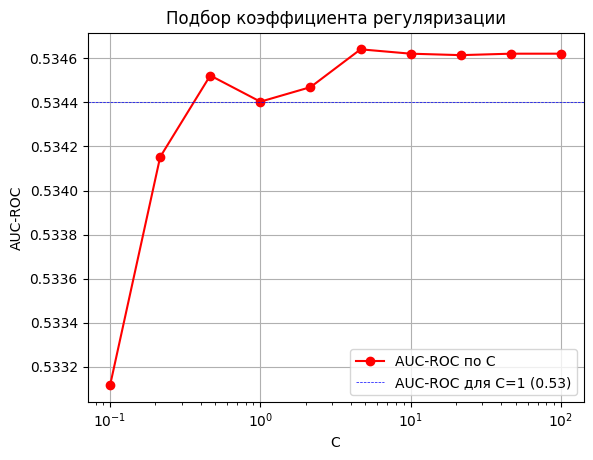

In [30]:
# Построение графика AUC-ROC от C
plt.plot(Cs, scores, 'ro-', label='AUC-ROC по C')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Подбор коэффициента регуляризации')

# Горизонтальная линия для дефолтного C
plt.axhline(y=score_C_1, linewidth=.5, color='b', linestyle='dashed', label=f'AUC-ROC для C=1 ({score_C_1:.2f})')

plt.legend()
plt.grid()
plt.show()


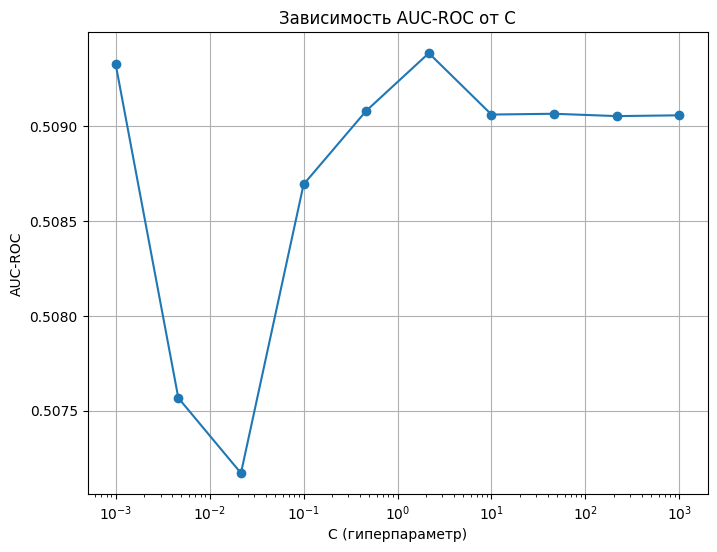

In [31]:
# 2.3График зависимости AUC-ROC от C
results = pd.DataFrame(grid.cv_results_)
plt.figure(figsize=(8, 6))
plt.semilogx(results['param_C'], results['mean_test_score'], marker='o')
plt.xlabel('C (гиперпараметр)')
plt.ylabel('AUC-ROC')
plt.title('Зависимость AUC-ROC от C')
plt.grid()
plt.show()

In [35]:
# 3. Сохранение бейслайна в CSV
baseline_metrics = []

# Проходим по каждой строке и добавляем данные в словарь
for i in range(len(df)):
    row_metrics = {
        'Date': df['date'].iloc[i],
        'sp 500 open': df['sp500 open'].iloc[i],
        'Best_C': best_C,
        'AUC-ROC': auc_score
    }
    baseline_metrics.append(row_metrics)

In [36]:
# Создание DataFrame из списка словарей
baseline_df = pd.DataFrame(baseline_metrics)

# Сохранение в CSV файл
baseline_path = 'baseline_metrics.csv'
baseline_df.to_csv(baseline_path, index=False)


print(baseline_df.head())

         Date  sp 500 open    Best_C   AUC-ROC
0  2010-01-14       114.49  2.154435  0.534621
1  2010-01-15       114.73  2.154435  0.534621
2  2010-01-18          NaN  2.154435  0.534621
3  2010-01-19       113.62  2.154435  0.534621
4  2010-01-20       114.28  2.154435  0.534621
